In [1]:
import torch
from torch.utils.data import DataLoader
from guided_diffusion import *
from plotting_utils import *
from model3 import UNETv8
from tqdm import tqdm

In [2]:
input_folder = r'C:\Users\sebas\Documents\Data\DiffusionBeamformer\input_id'
output_folder = r'C:\Users\sebas\Documents\Data\DiffusionBeamformer\target_enh'

data = CustomDataset(input_folder, output_folder, transform=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else torch.device('cpu'))

In [3]:
# Define beta schedule
T = 1000
# Pre-calculate different terms for closed form
beta, gamma = linear_beta_schedule(timesteps=T, start=1e-4, end=0.03, device=device)

Num params:  31232993


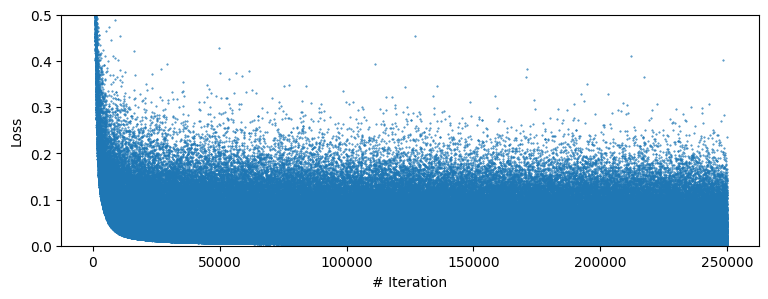

In [5]:
from model4 import UNETv10
device = torch.device("cuda:0" if torch.cuda.is_available() else torch.device('cpu'))
save_dir = r'.\weights_v10_T1000'
training_epochs = 200
model = UNETv10(in_channels=3, out_channels=1).to(device)
model.load_state_dict(torch.load(f"{save_dir}\\model_{training_epochs}.pth", map_location=device))
print("Num params: ", sum(p.numel() for p in model.parameters()))

loss_npy = np.load(f"{save_dir}\\loss_{training_epochs}.npy")
plt.figure(figsize=(9,3))
loss_npy = np.load(f"{save_dir}\\loss_{training_epochs}.npy")
plt.scatter([x for x in range(len(loss_npy))],loss_npy, s=0.2)
plt.xlabel('# Iteration')
plt.ylabel('Loss')
plt.ylim(0,0.5)
plt.show()

In [37]:
BATCH_SIZE = 1
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

x_sample, y_sample = next(iter(dataloader))
x_sample = x_sample.to(device)
y_sample = y_sample.to(device)

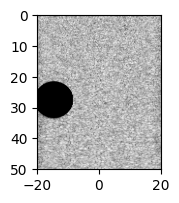

In [38]:
plt.figure(figsize=(10,2))
show_tensor_image(y_sample)
plt.show()

Timestep 1000 | 2024-01-10 12:43:32.502038


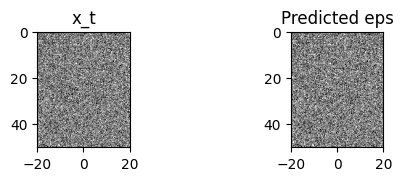

Timestep 980 | 2024-01-10 12:43:55.675234


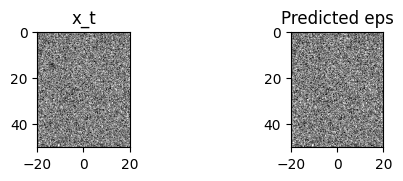

Timestep 960 | 2024-01-10 12:44:18.594503


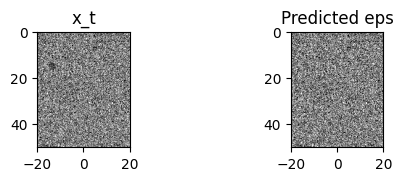

Timestep 940 | 2024-01-10 12:44:41.658508


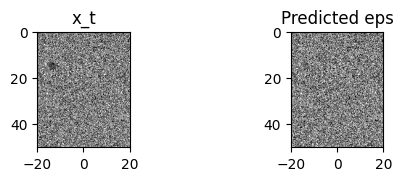

Timestep 920 | 2024-01-10 12:45:04.866240


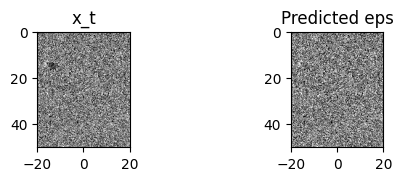

Timestep 900 | 2024-01-10 12:45:27.891072


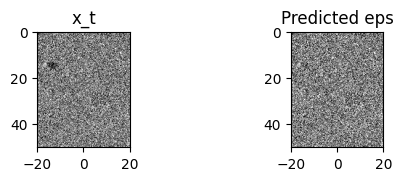

Timestep 880 | 2024-01-10 12:45:50.981543


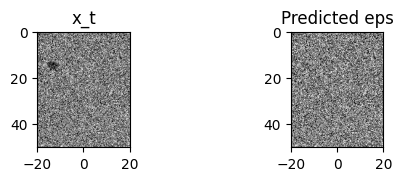

Timestep 860 | 2024-01-10 12:46:14.602127


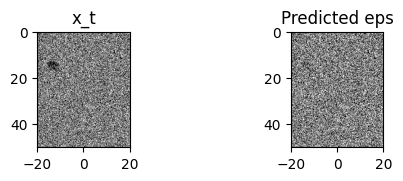

Timestep 840 | 2024-01-10 12:46:37.723417


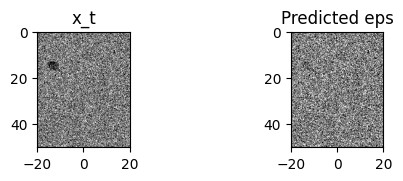

Timestep 820 | 2024-01-10 12:47:00.833631


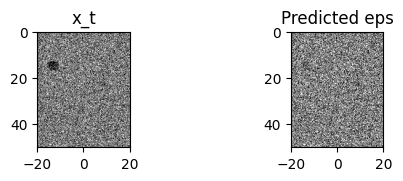

Timestep 800 | 2024-01-10 12:47:24.023533


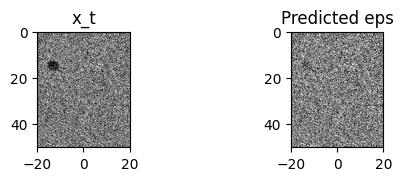

Timestep 780 | 2024-01-10 12:47:47.171488


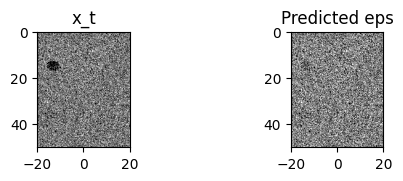

Timestep 760 | 2024-01-10 12:48:10.414489


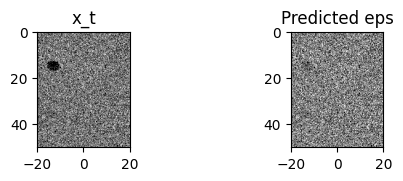

Timestep 740 | 2024-01-10 12:48:33.643590


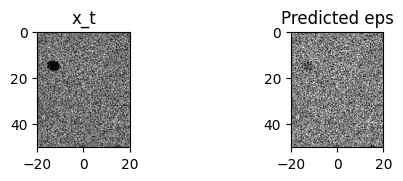

Timestep 720 | 2024-01-10 12:48:56.834597


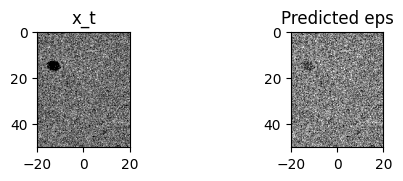

Timestep 700 | 2024-01-10 12:49:20.020622


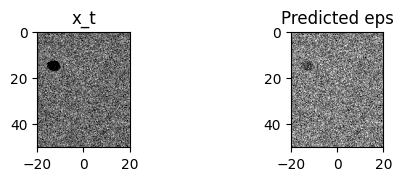

Timestep 680 | 2024-01-10 12:49:43.199764


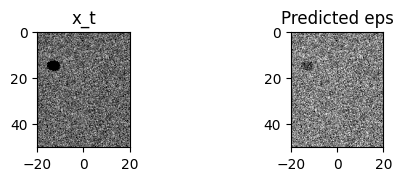

Timestep 660 | 2024-01-10 12:50:06.344575


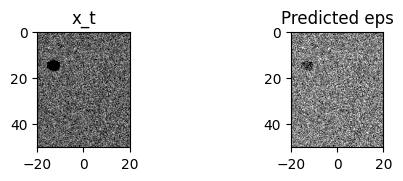

Timestep 640 | 2024-01-10 12:50:29.443535


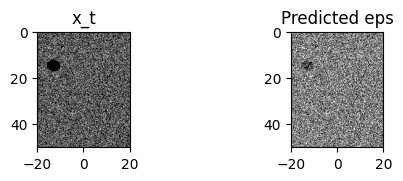

Timestep 620 | 2024-01-10 12:50:52.591881


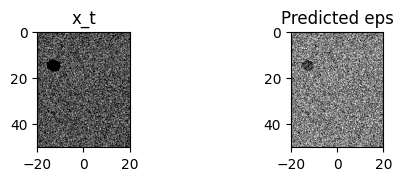

Timestep 600 | 2024-01-10 12:51:15.669309


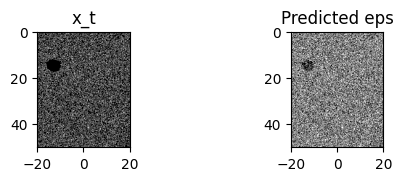

Timestep 580 | 2024-01-10 12:51:38.713140


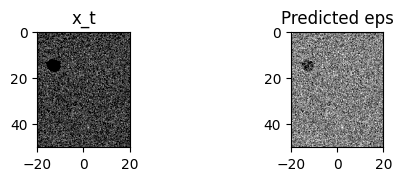

KeyboardInterrupt: 

In [53]:
from datetime import datetime as dt
with torch.inference_mode():
    T = len(beta)
    y_shape = list(x_sample.shape)
    y_shape[1] = 1
    y_gen = torch.randn(y_shape, device=device)

    intermediate_gen = []
    intermediate_eps = []

    for i in range(T,0,-1):
        t = torch.full((y_shape[0],), i-1, device=device, dtype=torch.long)

        device = beta.device
        alpha = 1. - beta
        gamma = torch.cumprod(alpha, axis=0)
        gamma_prev = torch.cat((torch.Tensor([1]).to(device), gamma[:-1]))

        beta_t = get_index_from_list(beta, t, y_gen.shape)
        alpha_t = get_index_from_list(alpha, t, y_gen.shape)
        gamma_t = get_index_from_list(gamma, t, y_gen.shape)
        gamma_t_prev = get_index_from_list(gamma_prev, t, y_gen.shape)

        input = torch.cat((x_sample, y_gen), 1)
        eps = model(input, t)
        # eps = eps - eps.mean(dim=2, keepdim=True).mean(dim=3, keepdim=True)
        
        # Call model (current image - noise prediction)
        model_mean = (1/alpha_t.sqrt()) * (y_gen - beta_t * eps / (1 - gamma_t).sqrt())
        posterior_variance_t = beta_t * (1. - gamma_t_prev) / (1. - gamma_t)

        noise = torch.randn_like(y_gen)
        y_gen = model_mean + torch.sqrt(posterior_variance_t) * noise
        y_gen = torch.clamp(y_gen, -1.0, 1.0)
        intermediate_gen.append(y_gen.detach().cpu())
        intermediate_eps.append(eps.detach().cpu())

        if i % 20==0:
            print(f'Timestep {i:02d} | {dt.now()}')
            plt.figure(figsize=(6,1.5))
            plt.subplot(1,2,1)
            show_tensor_image(y_gen.detach().cpu())
            plt.title('x_t')
            plt.subplot(1,2,2)
            show_tensor_image(eps.detach().cpu())
            plt.title('Predicted eps')
            plt.show()

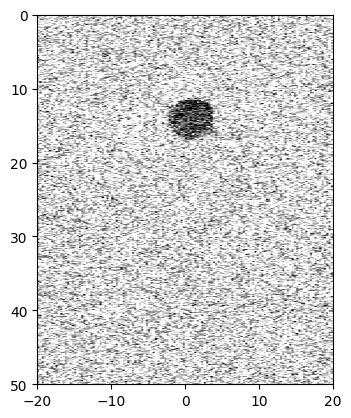

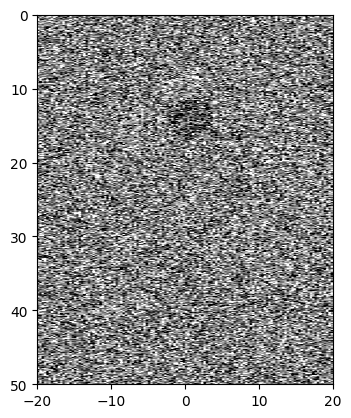

In [47]:
timestep = 680
show_tensor_image(intermediate_gen[T-timestep])
plt.show()
show_tensor_image(intermediate_eps[T-timestep])
plt.show()


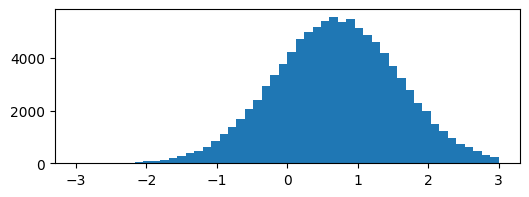

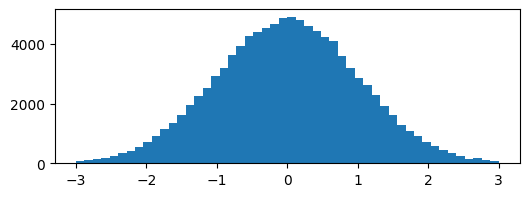

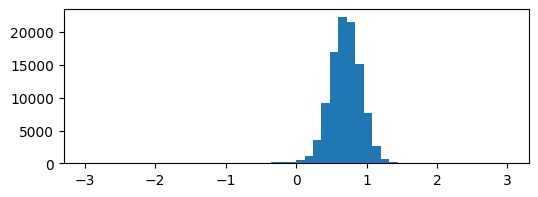

In [51]:
plt.figure(figsize=(6,2))
plt.hist(intermediate_gen[T-timestep].numpy().flatten(),50,(-3,3))
plt.show()
plt.figure(figsize=(6,2))
plt.hist(intermediate_eps[T-timestep].numpy().flatten(),50,(-3,3))
plt.show()

diff = intermediate_gen[T-timestep] - intermediate_eps[T-timestep]
plt.figure(figsize=(6,2))
plt.hist(diff.numpy().flatten(),50,(-3,3))
plt.show()

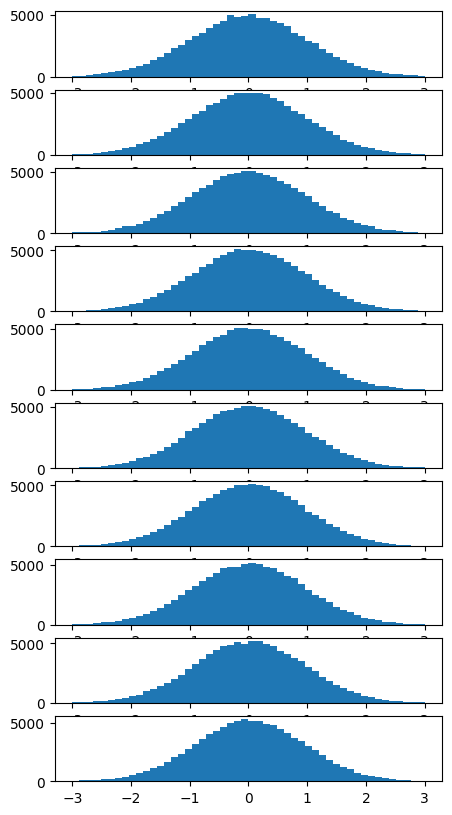

In [23]:
num_intermediate = len(intermediate)
plt.figure(figsize=(5,10))
for id, y_gen in enumerate(intermediate):
    plt.subplot(num_intermediate,1, id+1)
    plt.hist(y_gen.numpy().flatten(),50,(-3,3))
plt.show()